In [ ]:
import numpy as np
from transformers import  GPT2Config, GPT2Model, GPT2Tokenizer
config = {
    "file_dir":"CitiBike_dataset/bike_pick/",
    "epochs": 300,
    "num_nodes":250,
    "lrate": 1e-3,
    "batch_size": 64,
    "input_dim": 3,
    "clip": 5.0,
    "es_patience": 100,
    "input_len": 12,
    "output_len": 12,
    "print_every": 50,
    "wdecay":0.0001,
    "save": "./",
}

In [2]:
def load_dataset(dataset_dir, batch_size, valid_batch_size=None, test_batch_size=None):
    data = {}
    for category in ["train", "val", "test"]:
        cat_data = np.load(os.path.join(dataset_dir, category + ".npz"))
        data["x_" + category] = cat_data["x"]
        data["y_" + category] = cat_data["y"]
    scaler = StandardScaler(
        mean=data["x_train"][..., 0].mean(), std=data["x_train"][..., 0].std()
    )
    # Data format
    for category in ["train", "val", "test"]:
        data["x_" + category][..., 0] = scaler.transform(data["x_" + category][..., 0])

    print("Perform shuffle on the dataset")
    random_train = torch.arange(int(data["x_train"].shape[0]))
    random_train = torch.randperm(random_train.size(0))
    data["x_train"] = data["x_train"][random_train, ...]
    data["y_train"] = data["y_train"][random_train, ...]

    random_val = torch.arange(int(data["x_val"].shape[0]))
    random_val = torch.randperm(random_val.size(0))
    data["x_val"] = data["x_val"][random_val, ...]
    data["y_val"] = data["y_val"][random_val, ...]
    data["train_loader"] = DataLoader(data["x_train"], data["y_train"], batch_size)
    data["val_loader"] = DataLoader(data["x_val"], data["y_val"], valid_batch_size)
    data["test_loader"] = DataLoader(data["x_test"], data["y_test"], test_batch_size)
    data["scaler"] = scaler

    return data

In [3]:
# Few-shot load_dataset
# def load_dataset(dataset_dir, batch_size, valid_batch_size=None, test_batch_size=None, train_ratio=0.1):
#     data = {}

#     for category in ["train", "val", "test"]:
#         cat_data = np.load(os.path.join(dataset_dir, category + ".npz"))
#         data["x_" + category] = cat_data["x"]
#         data["y_" + category] = cat_data["y"]

#
#     scaler = StandardScaler(
#         mean=data["x_train"][..., 0].mean(),
#         std=data["x_train"][..., 0].std()
#     )

#
#     for category in ["train", "val", "test"]:
#         data["x_" + category][..., 0] = scaler.transform(data["x_" + category][..., 0])

#
#     num_train = data["x_train"].shape[0]
#     indices = np.random.permutation(num_train)
#     few_shot_size = int(num_train * train_ratio)
#     selected_indices = indices[:few_shot_size]

#     data["x_train"] = data["x_train"][selected_indices, ...]
#     data["y_train"] = data["y_train"][selected_indices, ...]

#     data["train_loader"] = DataLoader(data["x_train"], data["y_train"], batch_size)
#     data["val_loader"] = DataLoader(data["x_val"], data["y_val"], batch_size)
#     data["test_loader"] = DataLoader(data["x_test"], data["y_test"], batch_size)

#     data["scaler"] = scaler
#     return data

In [4]:
import numpy as np
import os
import scipy.sparse as sp
import torch
import pickle

class DataLoader(object):
    def __init__(self, xs, ys, batch_size, pad_with_last_sample=True):
        self.batch_size = batch_size
        self.current_ind = 0
        if pad_with_last_sample:
            num_padding = (batch_size - (len(xs) % batch_size)) % batch_size
            x_padding = np.repeat(xs[-1:], num_padding, axis=0)
            y_padding = np.repeat(ys[-1:], num_padding, axis=0)
            xs = np.concatenate([xs, x_padding], axis=0)
            ys = np.concatenate([ys, y_padding], axis=0)
        self.size = len(xs)
        self.num_batch = int(self.size // self.batch_size)
        self.xs = xs
        self.ys = ys

    def shuffle(self):
        permutation = np.random.permutation(self.size)
        xs, ys = self.xs[permutation], self.ys[permutation]
        self.xs = xs
        self.ys = ys

    def get_iterator(self):
        self.current_ind = 0

        def _wrapper():
            while self.current_ind < self.num_batch:
                start_ind = self.batch_size * self.current_ind
                end_ind = min(self.size, self.batch_size * (self.current_ind + 1))
                x_i = self.xs[start_ind:end_ind, ...]
                y_i = self.ys[start_ind:end_ind, ...]
                yield (x_i, y_i)
                self.current_ind += 1

        return _wrapper()


class StandardScaler:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def transform(self, data):
        return (data - self.mean) / self.std

    def inverse_transform(self, data):
        return (data * self.std) + self.mean


def load_pickle(pickle_file):
    try:
        with open(pickle_file, 'rb') as f:
            pickle_data = pickle.load(f)
    except UnicodeDecodeError as e:
        with open(pickle_file, 'rb') as f:
            pickle_data = pickle.load(f, encoding='latin1')
    except Exception as e:
        print('Unable to load data ', pickle_file, ':', e)
        raise e
    return pickle_data

In [5]:
# Evaluation metrics
def MAE_torch(pred, true, mask_value=None):
    if mask_value != None:
        mask = torch.gt(true, mask_value)
        pred = torch.masked_select(pred, mask)
        true = torch.masked_select(true, mask)
    return torch.mean(torch.abs(true - pred))


def MAPE_torch(pred, true, mask_value=None):
    if mask_value != None:
        mask = torch.gt(true, mask_value)
        pred = torch.masked_select(pred, mask)
        true = torch.masked_select(true, mask)
    return torch.mean(torch.abs(torch.div((true - pred), true)))


def RMSE_torch(pred, true, mask_value=None):
    if mask_value != None:
        mask = torch.gt(true, mask_value)
        pred = torch.masked_select(pred, mask)
        true = torch.masked_select(true, mask)
    return torch.sqrt(torch.mean((pred - true) ** 2))


def WMAPE_torch(pred, true, mask_value=None):
    if mask_value != None:
        mask = torch.gt(true, mask_value)
        pred = torch.masked_select(pred, mask)
        true = torch.masked_select(true, mask)
    loss = torch.sum(torch.abs(pred - true)) / torch.sum(torch.abs(true))
    return loss

def metric(pred, real):
    mae = MAE_torch(pred, real, 0).item()
    mape = MAPE_torch(pred, real,0).item()
    wmape = WMAPE_torch(pred, real, 0).item()
    rmse = RMSE_torch(pred, real, 0).item()
    return mae, mape, rmse, wmape

In [6]:
#Temporal Embedding layer
import torch.nn as nn
class TemporalEmbedding(nn.Module):
    def __init__(self, time, features):
        super(TemporalEmbedding, self).__init__()

        self.time = time
        self.time_day = nn.Parameter(torch.empty(time, features))
        nn.init.xavier_uniform_(self.time_day)
        self.time_week = nn.Parameter(torch.empty(7, features))
        nn.init.xavier_uniform_(self.time_week)

    def forward(self, x):
        day_emb = x[..., 1]
        time_day = self.time_day[(day_emb[:, -1, :] * self.time).type(torch.LongTensor)]
        time_day = time_day.transpose(1, 2).unsqueeze(-1)
        week_emb = x[..., 2]
        time_week = self.time_week[(week_emb[:, -1, :]).type(torch.LongTensor)]
        time_week = time_week.transpose(1, 2).unsqueeze(-1)
        tem_emb = time_day + time_week
        return tem_emb

In [7]:
#Spatial Embedding Layer
class SpatialEmbedding(nn.Module):
    def __init__(self, num_nodes, features):
        super(SpatialEmbedding, self).__init__()

        self.num_nodes = num_nodes
        self.features = features
        self.embeddings = nn.Parameter(torch.empty(num_nodes, features))
        nn.init.xavier_uniform_(self.embeddings)

    def forward(self, batch_size):

        spa_emb = (
            self.embeddings.unsqueeze(0)          # (1, num_nodes, features)
            .expand(batch_size, -1, -1)          # (batch_size, num_nodes, features)
            .transpose(1, 2)                 # (batch_size, features, num_nodes)
            .unsqueeze(-1)                    # (batch_size, features, num_nodes, 1)
        )
        return spa_emb

In [8]:
# Cross Attention Layer
from math import sqrt

class CrossAttentionLayer(nn.Module):
    def __init__(self, d_model, n_heads, attention_dropout=0.1):
        super(CrossAttentionLayer, self).__init__()

        d_keys = d_model // n_heads
        self.query_projection = nn.Linear(d_model, d_keys * n_heads)
        self.key_projection = nn.Linear(d_model, d_keys * n_heads)
        self.value_projection = nn.Linear(d_model, d_keys * n_heads)
        self.out_projection = nn.Linear(d_keys * n_heads, d_model)

        self.n_heads = n_heads
        self.dropout = nn.Dropout(attention_dropout)

    def forward(self, query, key, value):
        B, L, _ = query.shape
        S = key.shape[1]
        query = self.query_projection(query)
        key = self.key_projection(key)
        value = self.value_projection(value)
        query = query.view(B, L, self.n_heads, -1)
        key = key.view(B, S, self.n_heads, -1)
        value = value.view(B, S, self.n_heads, -1)
        scale = 1. / sqrt(query.shape[-1])
        scores = torch.einsum("blhd,bshd->bhls", query, key)
        attention_weights = self.dropout(torch.softmax(scale * scores, dim=-1))
        context = torch.einsum("bhls,bshd->blhd", attention_weights, value)
        context = context.contiguous().view(B, L, -1)


        return self.out_projection(context)

In [9]:
# Prompt-as-Prefix Layer
def build_dynamic_prompt(input_data):
    if isinstance(input_data, torch.Tensor):
        input_data = input_data.detach().cpu().numpy()
    B, T, N, F = input_data.shape


    flows = input_data[..., 0]  # shape: (B, T, N)


    avg_flow = flows.mean()
    max_flow = flows.max()
    min_flow = flows.min()
    median_flow = np.median(flows)
    avg_hour_feature = input_data[..., 1].mean(axis=(0, 2))
    avg_day_feature = input_data[..., 2].mean(axis=(0, 2))

    hour_trend = np.polyfit(np.arange(T), avg_hour_feature, 1)[0]
    day_trend = np.polyfit(np.arange(T), avg_day_feature, 1)[0]



    prompt = f"""
      <|start_prompt|>
      Dataset Description:This dataset records taxi pick up flow from 266 city zones, including hourly and daily pick up traffic information.
      Input Statistics:
      Average pickup flow: {avg_flow:.2f} per time step.
      Max pickup flow: {max_flow:.2f}
      Min pickup flow: {min_flow:.2f}
      Median pickup flow: {median_flow:.2f}
      Hourly trend {hour_trend:.4f}
      Daily trend {day_trend:.4f}
      Task Description:Given a sequence of the last {T} time steps for all zones, predict the pick up flow for the next 12 time steps.
      <|end_prompt|>""".strip()

    return prompt

In [10]:
# #cross attention
# import torch.nn.functional as F
# class CrossAttentionLayer(nn.Module):
#     def __init__(self, d_model, num_heads):
#         super(CrossAttentionLayer, self).__init__()
#         self.d_model = d_model
#         self.num_heads = num_heads

#         self.query = nn.Linear(d_model, d_model)
#         self.key = nn.Linear(d_model, d_model)
#         self.value = nn.Linear(d_model, d_model)

#         self.out = nn.Linear(d_model, d_model)

#     def forward(self, query, key, value):

#         Q = self.query(query)
#         K = self.key(key)
#         V = self.value(value)

#         scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.d_model, dtype=torch.float32))
#         attn_weights = F.softmax(scores, dim=-1)
#         context = torch.matmul(attn_weights, V)
#         output = self.out(context)

#         return output

In [11]:
class ST_GPT(nn.Module):
    def __init__(
        self,
        input_dim,
        channels4,
        num_nodes,
        input_len,
        output_len,
        num_heads,
        device
    ):
        super().__init__()

        self.num_nodes = num_nodes
        self.node_dim = channels
        self.input_len = input_len
        self.input_dim = input_dim
        self.output_len = output_len
        self.num_heads = num_heads
        self.device = device

        if num_nodes == 170 or num_nodes == 307:
            time = 288
        elif num_nodes == 250 or num_nodes == 266:
            time = 48

        gpt_channel = 256
        to_gpt_channel = 768
        self.tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

        self.gpt2_model = GPT2Model.from_pretrained("gpt2")
        self.gpt2_model.h = self.gpt2_model.h[:2]
        for param in self.gpt2_model.parameters():
            param.requires_grad = False
        self.gpt2_embeddings = self.gpt2_model.wte
        self.embedding_weights = self.gpt2_model.wte.weight
        self.Temb = TemporalEmbedding(time, gpt_channel)
        self.Spat = SpatialEmbedding(num_nodes, gpt_channel)
        self.start_conv = nn.Conv2d(self.input_dim * self.input_len, gpt_channel, kernel_size=(1, 1))
        self.feature_fusion = nn.Conv2d(gpt_channel * 3, to_gpt_channel, kernel_size=(1, 1))

        # Add mapping layer to reduce dictionary size to 1000
        self.mapping_layer = nn.Linear(self.embedding_weights.shape[0], 1000)

        self.cross_attention = CrossAttentionLayer(to_gpt_channel, num_heads)
        self.regression_layer = nn.Conv2d(to_gpt_channel, self.output_len, kernel_size=(1, 1))
    def param_num(self):
        return sum(param.numel() for param in self.parameters() if param.requires_grad)
    def forward(self, history_data):
        input_data = history_data
        batch_size, _, num_nodes, _ = input_data.shape
        history_data = history_data.permute(0, 3, 2, 1)
        input_data = input_data.transpose(1, 2).contiguous()
        input_data = (
            input_data.view(batch_size, num_nodes, -1).transpose(1, 2).unsqueeze(-1)
        )
        input_data = self.start_conv(input_data)
        tem_emb = self.Temb(history_data)
        spa_emb = self.Spat(batch_size)
        data_st = torch.cat([input_data] + [tem_emb] + [spa_emb], dim=1)
        data_st = self.feature_fusion(data_st)
        data_st = data_st.permute(0, 2, 1, 3).squeeze(-1)


        mapped = self.mapping_layer(self.embedding_weights.permute(1, 0)).permute(1, 0)
        mapped = mapped.unsqueeze(0).expand(batch_size, -1, -1).contiguous()
        data_ali = self.cross_attention(data_st, mapped, mapped)

        desc_dataset = build_dynamic_prompt(history_data)
        tokens = self.tokenizer(desc_dataset, return_tensors="pt")
        tokens_ids = tokens["input_ids"].to(history_data.device)
        with torch.no_grad():
            prompt_embed = self.gpt2_embeddings(tokens_ids)
        prompt_len = prompt_embed.size(1)

        prompt_embeddings = prompt_embed.repeat(batch_size, 1, 1).to(history_data.device)
        gpt_input = torch.cat([prompt_embeddings, data_st], dim=1)
        gpt_output = self.gpt2_model(inputs_embeds=gpt_input).last_hidden_state

        data_out = gpt_output[:, prompt_len:, :]
        data_out = data_out.permute(0, 2, 1).unsqueeze(-1)

        prediction = self.regression_layer(data_out)

        return prediction

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
def seed_it(seed):
    random.seed(seed)
    os.environ["PYTHONSEED"] = str(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.enabled = True
    torch.manual_seed(seed)

In [13]:
## Without GPT
# import torch.optim as optim
# class trainer:
#     def __init__(
#         self,
#         scaler,
#         lrate,
#         wdecay,
#         input_dim,
#         num_nodes,
#         input_len,
#         output_len,
#         device
#     ):
#         self.model = ST_GPT(
#             input_dim=input_dim, num_nodes=num_nodes, input_len=input_len, output_len=output_len, device=device
#         )
#         self.model.to(device)

#         #self.optimizer = Ranger(self.model.parameters(), lr=lrate, weight_decay=wdecay)
#         self.optimizer = optim.Adam(self.model.parameters(), lr=lrate, weight_decay=wdecay)
#         self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', patience=5, factor=0.1, verbose=True)
#         self.loss = MAE_torch
#         self.scaler = scaler
#         self.clip = 5
#         print("The number of parameters: {}".format(self.model.param_num()))
#         print(self.model)

#     def train(self, input, real_val):
#         self.model.train()
#         self.optimizer.zero_grad()
#         output = self.model(input)
#         output = output.transpose(1, 3)
#         real = torch.unsqueeze(real_val, dim=1)
#         predict = self.scaler.inverse_transform(output)
#         loss = self.loss(predict, real, 0.0)
#         loss.backward()
#         if self.clip is not None:
#             torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip)
#         self.optimizer.step()
#         mape = MAPE_torch(predict, real, 0.0).item()
#         rmse = RMSE_torch(predict, real, 0.0).item()
#         wmape = WMAPE_torch(predict, real, 0.0).item()
#         return loss.item(), mape, rmse, wmape

#     def eval(self, input, real_val):
#         self.model.eval()
#         output = self.model(input)
#         output = output.transpose(1, 3)
#         real = torch.unsqueeze(real_val, dim=1)
#         predict = self.scaler.inverse_transform(output)
#         loss = self.loss(predict, real, 0.0)
#         mape = MAPE_torch(predict, real, 0.0).item()
#         rmse = RMSE_torch(predict, real, 0.0).item()
#         wmape = WMAPE_torch(predict, real, 0.0).item()
#         return loss.item(), mape, rmse, wmape

#     def step_scheduler(self, val_loss):
#         self.scheduler.step(val_loss)

In [ ]:
import torch
import numpy as np
import pandas as pd
import argparse
import time
import os
import random

def train():
    seed_it(6666)
    file_dir = config["file_dir"]
    dataloader = load_dataset(dataset_dir=file_dir, batch_size=config["batch_size"], valid_batch_size=config["batch_size"], test_batch_size=config["batch_size"])
    print(dataloader['x_train'].shape)
    print(dataloader['x_val'].shape)
    print(dataloader['x_test'].shape)
    scaler = dataloader["scaler"]
    loss = 9999999
    test_log = 999999
    epochs_since_best_mae = 0
    path = "./"
    his_loss = []
    val_time = []
    train_time = []
    result = []
    test_result = []


    engine = trainer(
        scaler,
        config["lrate"],
        config["wdecay"],
        config["input_dim"],
        config["num_nodes"],
        config["input_len"],
        config["output_len"],
        device
    )

    print("start training...", flush=True)
    for i in range(1, config["epochs"] + 1):
        train_loss = []
        train_mape = []
        train_rmse = []
        train_wmape = []

        t1 = time.time()
        for iter, (x, y) in enumerate(dataloader["train_loader"].get_iterator()):
            trainx = torch.Tensor(x).to(device)  # 64 12 250 1
            trainx = trainx.transpose(1, 3)
            trainy = torch.Tensor(y).to(device)
            trainy = trainy.transpose(1, 3)
            metrics = engine.train(trainx, trainy[:, 0, :, :])
            train_loss.append(metrics[0])
            train_mape.append(metrics[1])
            train_rmse.append(metrics[2])
            train_wmape.append(metrics[3])

        t2 = time.time()
        log = "Epoch: {:03d}, Training Time: {:.4f} secs"
        print(log.format(i, (t2 - t1)))
        train_time.append(t2 - t1)

        # validation
        valid_loss = []
        valid_mape = []
        valid_wmape = []
        valid_rmse = []

        s1 = time.time()
        for iter, (x, y) in enumerate(dataloader["val_loader"].get_iterator()):
            testx = torch.Tensor(x).to(device)
            testx = testx.transpose(1, 3)
            testy = torch.Tensor(y).to(device)
            testy = testy.transpose(1, 3)
            metrics = engine.eval(testx, testy[:, 0, :, :])
            valid_loss.append(metrics[0])
            valid_mape.append(metrics[1])
            valid_rmse.append(metrics[2])
            valid_wmape.append(metrics[3])

        s2 = time.time()
        log = "Epoch: {:03d}, Inference Time: {:.4f} secs"
        print(log.format(i, (s2 - s1)))
        val_time.append(s2 - s1)

        mtrain_loss = np.mean(train_loss)
        mtrain_mape = np.mean(train_mape)
        mtrain_wmape = np.mean(train_wmape)
        mtrain_rmse = np.mean(train_rmse)

        mvalid_loss = np.mean(valid_loss)
        mvalid_mape = np.mean(valid_mape)
        mvalid_wmape = np.mean(valid_wmape)
        mvalid_rmse = np.mean(valid_rmse)

        his_loss.append(mvalid_loss)
        print("-----------------------")

        train_m = dict(
            train_loss=np.mean(train_loss),
            train_rmse=np.mean(train_rmse),
            train_mape=np.mean(train_mape),
            train_wmape=np.mean(train_wmape),
            valid_loss=np.mean(valid_loss),
            valid_rmse=np.mean(valid_rmse),
            valid_mape=np.mean(valid_mape),
            valid_wmape=np.mean(valid_wmape),
        )
        train_m = pd.Series(train_m)
        result.append(train_m)

        log = "Epoch: {:03d}, Train Loss: {:.4f}, Train RMSE: {:.4f}, Train MAPE: {:.4f}, Train WMAPE: {:.4f}, "
        print(
            log.format(i, mtrain_loss, mtrain_rmse, mtrain_mape, mtrain_wmape),
            flush=True,
        )
        log = "Epoch: {:03d}, Valid Loss: {:.4f}, Valid RMSE: {:.4f}, Valid MAPE: {:.4f}, Valid WMAPE: {:.4f}"
        print(
            log.format(i, mvalid_loss, mvalid_rmse, mvalid_mape, mvalid_wmape),
            flush=True,
        )

        if mvalid_loss < loss:
            loss = mvalid_loss
            torch.save(engine.model.state_dict(), path + "best_model.pth")
            bestid = i
            epochs_since_best_mae = 0
            print("Updating! Valid Loss:{:.4f}".format(mvalid_loss), end=", ")
            print("epoch: ", i)

            engine.step_scheduler(mvalid_loss)

        else:
            epochs_since_best_mae += 1
            print("No update")

        train_csv = pd.DataFrame(result)
        train_csv.round(8).to_csv(f"{path}/train.csv")

        if epochs_since_best_mae >= config["es_patience"] and i >= 200:
            break

    print("Average Training Time: {:.4f} secs/epoch".format(np.mean(train_time)))
    print("Average Inference Time: {:.4f} secs".format(np.mean(val_time)))

   
    print("Training ends")
    print("The epoch of the best result：", bestid)
    print("The valid loss of the best model", str(round(his_loss[bestid - 1], 4)))

    engine.model.load_state_dict(torch.load(path + "best_model.pth"))
    outputs = []
    realy = torch.Tensor(dataloader["y_test"]).to(device)
    realy = realy.transpose(1, 3)[:, 0, :, :]

    for iter, (x, y) in enumerate(dataloader["test_loader"].get_iterator()):
        testx = torch.Tensor(x).to(device)
        testx = testx.transpose(1, 3)
        with torch.no_grad():
            preds = engine.model(testx).transpose(1, 3)
        outputs.append(preds.squeeze())

    yhat = torch.cat(outputs, dim=0)
    yhat = yhat[: realy.size(0), ...]

    amae = []
    amape = []
    armse = []
    awmape = []

    test_m = []

    for i in range(config["output_len"]):
        pred = scaler.inverse_transform(yhat[:, :, i])
        real = realy[:, :, i]
        metrics = metric(pred, real)
        test_m = dict(
            test_loss=np.mean(metrics[0]),
            test_rmse=np.mean(metrics[2]),
            test_mape=np.mean(metrics[1]),
            test_wmape=np.mean(metrics[3]),
        )
        test_m = pd.Series(test_m)
        test_result.append(test_m)

        amae.append(metrics[0])
        amape.append(metrics[1])
        armse.append(metrics[2])
        awmape.append(metrics[3])

    log = "On average over 12 horizons, Test MAE: {:.4f}, Test RMSE: {:.4f}, Test MAPE: {:.4f}, Test WMAPE: {:.4f}"
    print(log.format(np.mean(amae), np.mean(armse), np.mean(amape), np.mean(awmape)))

    test_m = dict(
        test_loss=np.mean(amae),
        test_rmse=np.mean(armse),
        test_mape=np.mean(amape),
        test_wmape=np.mean(awmape),
    )
    test_m = pd.Series(test_m)
    test_result.append(test_m)

    test_csv = pd.DataFrame(test_result)
    test_csv.round(8).to_csv(f"{path}/test.csv")


In [17]:
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:21'
# Training
torch.cuda.empty_cache()
t1 = time.time()
train()
t2 = time.time()
print("Total time spent: {:.4f}".format(t2 - t1))

FileNotFoundError: [Errno 2] No such file or directory: 'CitiBike_dataset/bike_pick/train.npz'

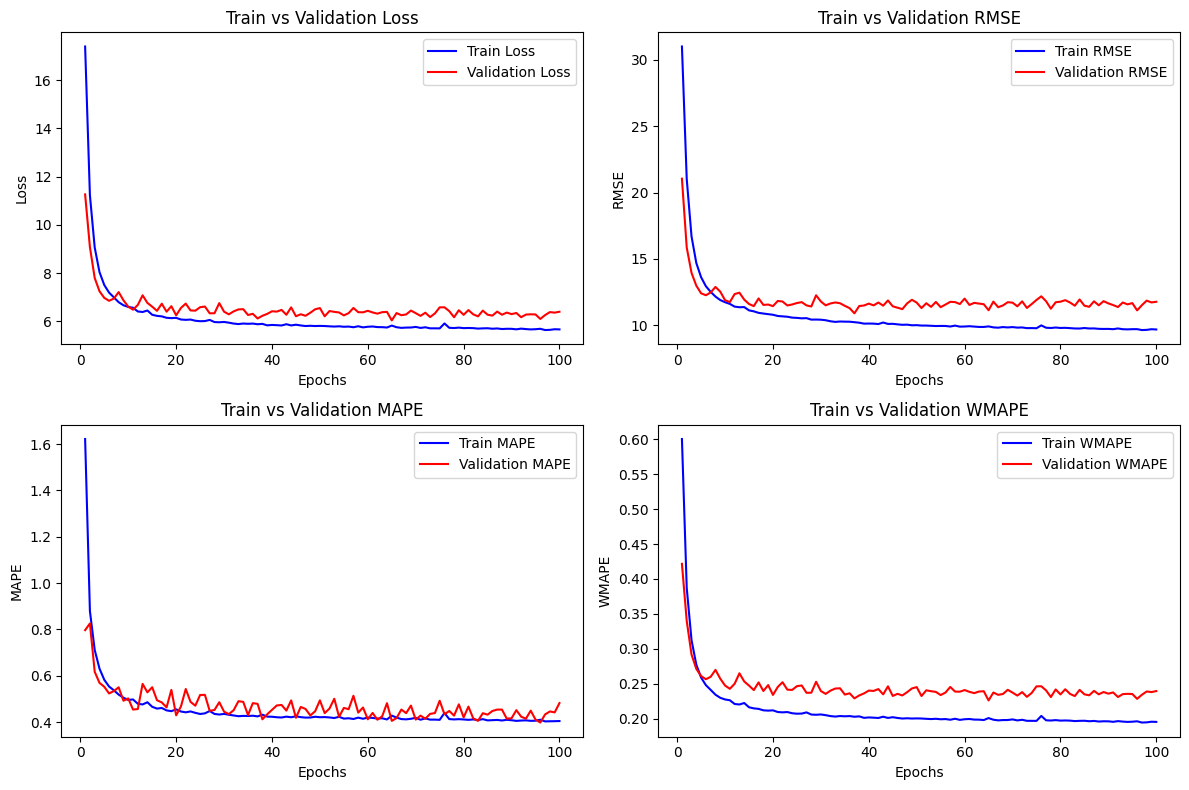

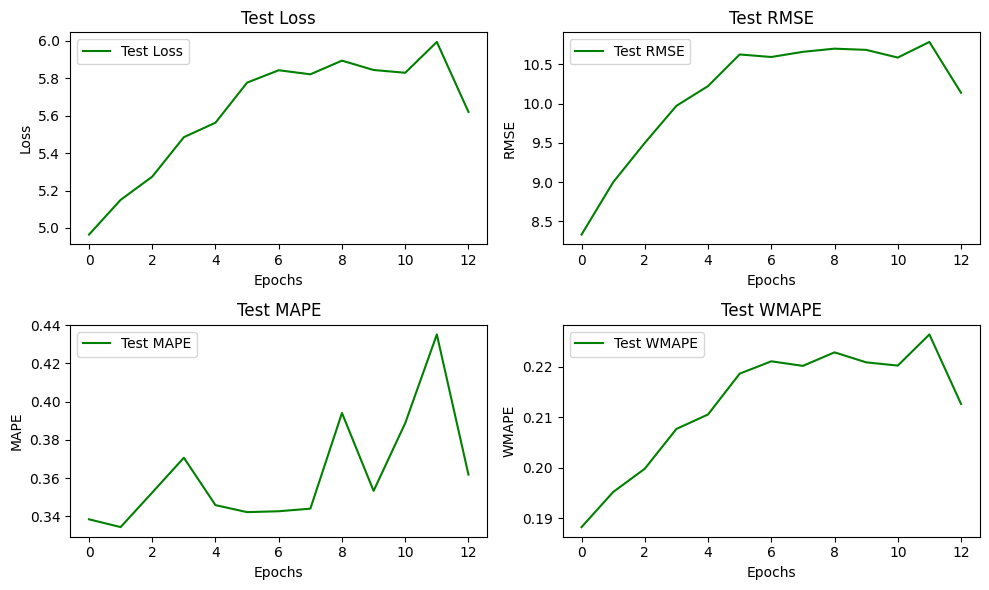

In [ ]:
import matplotlib.pyplot as plt


train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

epochs = train_df.index + 1

train_loss = train_df['train_loss']
train_rmse = train_df['train_rmse']
train_mape = train_df['train_mape']
train_wmape = train_df['train_wmape']

valid_loss = train_df['valid_loss']
valid_rmse = train_df['valid_rmse']
valid_mape = train_df['valid_mape']
valid_wmape = train_df['valid_wmape']

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss', color='blue')
plt.plot(epochs, valid_loss, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, train_rmse, label='Train RMSE', color='blue')
plt.plot(epochs, valid_rmse, label='Validation RMSE', color='red')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Train vs Validation RMSE')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs, train_mape, label='Train MAPE', color='blue')
plt.plot(epochs, valid_mape, label='Validation MAPE', color='red')
plt.xlabel('Epochs')
plt.ylabel('MAPE')
plt.title('Train vs Validation MAPE')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, train_wmape, label='Train WMAPE', color='blue')
plt.plot(epochs, valid_wmape, label='Validation WMAPE', color='red')
plt.xlabel('Epochs')
plt.ylabel('WMAPE')
plt.title('Train vs Validation WMAPE')
plt.legend()

plt.tight_layout()
plt.show()

test_loss = test_df['test_loss']
test_rmse = test_df['test_rmse']
test_mape = test_df['test_mape']
test_wmape = test_df['test_wmape']

plt.figure(figsize=(10, 6))

epochs = list(range(len(test_loss)))
plt.subplot(2, 2, 1)
plt.plot(epochs, test_loss, label='Test Loss', color='green')
plt.xlabel('Number of Forecasting-step')
plt.ylabel('Loss')
plt.title('Test Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, test_rmse, label='Test RMSE', color='green')
plt.xlabel('Number of Forecasting-step')
plt.ylabel('RMSE')
plt.title('Test RMSE')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs, test_mape, label='Test MAPE', color='green')
plt.xlabel('Epochs')
plt.ylabel('MAPE')
plt.title('Number of Forecasting-step')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, test_wmape, label='Test WMAPE', color='green')
plt.xlabel('Epochs')
plt.ylabel('WMAPE')
plt.title('Number of Forecasting-step')
plt.legend()

plt.tight_layout()
plt.show()